## Notebook on FineTuning different current state of the art CNN models

What to expect: <br/>
1. Application of Image Folder Dataloader
2. Application of model training, validation and test

Models included in this Notebook:
- InceptionV3
- ResNet50
- ResNet152
- EfficientNetV2-s
- DenseNet121
- VGG16_bn
- MaxViT

some things to note: 
- inceptionV3 requires images to be at least size 299, 299
- maxvit requires images to specifically be 224,224

### 1. Application of dataloader
Ensure that your dataset is in the following format
```
Image_Folder
|- Train
|  |- Class 1
|  |- Class 2
|
|- Validation
|  |- Class 1
|  |- Class 2
|
|- Test
|  |- Class 1
|  |- Class 2
```

In [1]:
#Necessary Imports
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#Parameter Setup
image_size = (224,224)
batch_size = 64

In [3]:
#Define transforms for image preprocessing
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

#No data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

In [4]:
# Create PyTorch datasets for training and validation
train_dataset = datasets.ImageFolder(
                    root='../input/CNN_landscape/Train', 
                    transform=train_transform
                    )
val_dataset = datasets.ImageFolder(
                    root='../input/CNN_landscape/Validation', 
                    transform=eval_transform
                    )
test_dataset = datasets.ImageFolder(
                    root='../input/CNN_landscape/Test', 
                    transform=eval_transform
                    )

# Create PyTorch dataloaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=batch_size, 
                    shuffle=True
                    )
val_dataloader = torch.utils.data.DataLoader(
                    val_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )
test_dataloader = torch.utils.data.DataLoader(
                    test_dataset, 
                    batch_size=batch_size, 
                    shuffle=True
                    )

In [5]:
def visualise_img(dataloader, class_list: list):
    """
    Function to visualize the first 9 images of the landscape dataset.

    Args:
        dataloader (DataLoader): PyTorch DataLoader object containing the dataset to visualize.
        class_list (list): List of class labels.
    """
    #Get the first batch of images and labels
    train_images, train_labels = next(iter(dataloader))
    batch_size = train_images.size(0)  # Get the batch size

    #Print the shape of the batch
    print(f"Images batch shape: {train_images.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

    #Create a 3x3 grid for visualization
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for i in range(3):
        for j in range(3):
            #Get the index of the image in the batch
            index = i * 3 + j

            if index < batch_size:
                #Prepare image to print
                img = train_images[index].squeeze().numpy().transpose((1, 2, 0))
                label = train_labels[index].item()

                #Plot the image
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Label: {label}, {class_list[label]}', loc='left')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


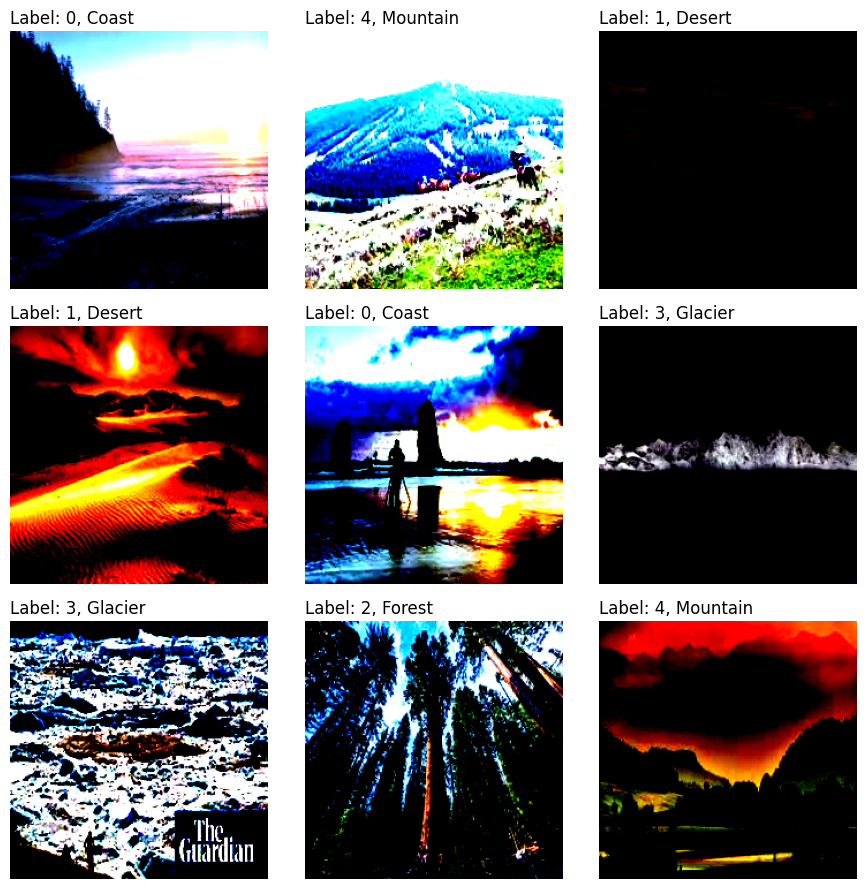

In [6]:
visualise_img(train_dataloader, train_dataset.classes)

### 2. Training and Evaluations Functions

In [7]:
def finetuning_eval(
    model, 
    criterion, 
    val_dataloader, 
    device:str='cuda'):

  """
  Evaluation function for finetuning CNN models

  Args:
    model: CNN model
    criterion: Loss function
    val_dataloader: Validation / Test dataloader
    device (str, optional): 'cpu' or 'cuda', defaults to cuda

  Returns:
      accuracy: float of the accuracy
      avg_val_loss: float of the average val loss
  """

  #set model to eval mode
  model.eval()

  #variables 
  val_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
      for image, label in val_dataloader:
        image = image.to(device)
        label = label.to(device)

        outputs = model(image) #predict label 
        loss = criterion(outputs, label) #calculate loss
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item() #check if predicted is the same as the label

  #calculate accuracy and loss
  accuracy = (correct / total) * 100
  avg_val_loss = val_loss / len(val_dataloader)

  return accuracy, avg_val_loss


In [8]:
def finetuning_train(model, 
                  criterion, 
                  optimiser, 
                  train_dataloader, 
                  val_dataloader=None, 
                  num_epochs:int=25, 
                  device:str='cuda', 
                  model_name:str=None):
  
  """
  Training function for CNN models

  Args:
    model: CNN model to be finetuned
    criterion: Loss function
    optimiser: Optimiser function of the model
    train_dataloader: Train Dataset
    val_dataloader (optional): Validation Dataset, use None if no Validation dataset
    num_epochs (int, optional): Number of training epochs, defaults to 25
    device (str, optional): cpu or cuda, defaults to cuda
    model_name (str, optional): Model Name for saving model, None if no saving to be done. Defaults to None

  Returns:
      train_loss: list of the average train loss per epoch
      val_loss: list of the average val loss per epoch
  """

  #initialising results container
  train_loss = []
  val_loss = []

  for epoch in range(num_epochs):

    #model in train mode
    model.train()
    training_loss = 0.0

    #training model
    for image, label in tqdm(train_dataloader):
      image = image.to(device)
      label = label.to(device)

      optimiser.zero_grad()
      outputs = model(image)
      loss = criterion(outputs, label)
      loss.backward()
      optimiser.step()
      training_loss += loss.item()

    epoch_loss = training_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} completed, training loss: {epoch_loss}")

    #train if there is a validation dataset
    if val_dataloader != None:
      accuracy, avg_val_loss = finetuning_eval(model, criterion, val_dataloader, device)
      print(f"Validation loss: {avg_val_loss}, Validation Accuracy: {accuracy:.2f}")
      val_loss.append(avg_val_loss)

    train_loss.append(epoch_loss)

    #saving best model based on lowest validation loss (no validation dataset = no best model saving)
    #only runs if there is a model name to save the model on
    if len(val_loss) > 1 and val_loss[-1] < min(val_loss[:-1]) and model_name!=None:
      torch.save(model, f'../models/cnn/{model_name}_best.pt')
      print("Best model saved")

  #saving the last model if there is a model name
  if model_name != None:
    torch.save(model, f'../models/cnn/{model_name}_{num_epochs}.pt')
  
  return train_loss, val_loss


In [ ]:
def visualise_graph(training_data:list, validation_data:list, y_label:str, x_label:str, ylim:list=None):
    """
    Plot a line graph against training and validation data

    Args:
        training_data (list): Training data to be plotted
        validation_data (list): Validation data to be plotted
        y_label (str): Label of y axis
        x_label (str): Label of x axis
        ylim (list, optional): Range of y axis, defaults to None
    """
    #plotting line graph of training data and validation data
    plt.plot(training_data, label='Train')
    plt.plot(validation_data, label='Validation')

    #labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'{y_label} against {x_label}')
    
    if ylim != None:
        plt.ylim(ylim)
        
    #show legend
    plt.legend()
    plt.show()
    

### 3. Base Finetuning Model Class

In [9]:
class PreTrainedCNNModels(torch.nn.Module):
    def __init__(self, model_type:str, num_unfreeze:int, num_class:int):
        super(PreTrainedCNNModels, self).__init__()
        """
        Class that contains InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit fine tuned models

        Args:
            model_type (str): Determines which pre-trained models to use
                              Must be: InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit
            num_unfreeze (int): Number of layers to unfreeze and finetune
            num_class (int): Number of output classes for the classification
        """
        #selecting model type
        if model_type == 'InceptionV3':
            self.model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
            self.model.aux_logits = False

        elif model_type == 'Resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        elif model_type == 'Resnet152':
            self.model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        elif model_type == 'EfficientNet':
            self.model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

        elif model_type == 'DenseNet':
            self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        
        elif model_type == 'VGG16':
            self.model = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        elif model_type == 'MaxVit':
            self.model = models.maxvit_t(weights=models.MaxVit_T_Weights.DEFAULT)
        
        else:
            raise Exception("Invalid model type chosen. Please select one of the following\n[InceptionV3, Resnet50, Resnet152, EfficientNet, DenseNet, VGG16, MaxVit]")

        
        #modifying final layer
        if model_type in ['InceptionV3', 'Resnet50', 'Resnet152']:
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_class)

        elif model_type == 'DenseNet':
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, num_class)

        else:
            self.model.classifier[-1] = torch.nn.Linear(self.model.classifier[-1].in_features, num_class)


        model_paramteres = list(self.model.parameters())
        #unfreeze last num_unfreeze layers
        for param in model_paramteres[-num_unfreeze:]:
            param.requires_grad = True

        #freeze rest of the layers
        for param in model_paramteres[:-num_unfreeze]:
            param.requires_grad = False


    def forward(self, images):
        return self.model(images)

### 4. Finetuning and Evaluation of models

In [11]:
#Clearing GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

484

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### InceptionV3

##### Training

In [154]:
model = PreTrainedCNNModels('InceptionV3', 2, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'incept_14')

In [ ]:
#plotting line graph of training loss and validation loss
visualise_graph(training_data=train_loss, 
                validation_data=val_loss,
                y_label="Loss",
                x_label="Epochs" )

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/incept_2_best.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 84.6, test_loss: 0.4788432940840721


#### ResNet50

##### Training

In [ ]:
model = PreTrainedCNNModels('Resnet50', 16, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'resnet50_10')

100%|██████████| 157/157 [00:17<00:00,  9.15it/s]


Epoch 1 completed, training loss: 1.3029213228802772
Validation loss: 1.0296263272563617, Validation Accuracy: 72.20


100%|██████████| 157/157 [00:16<00:00,  9.28it/s]


Epoch 2 completed, training loss: 0.9229578185992636
Validation loss: 0.8060246258974075, Validation Accuracy: 74.73
Best model saved


100%|██████████| 157/157 [00:17<00:00,  9.19it/s]


Epoch 3 completed, training loss: 0.7696430838791428
Validation loss: 0.7258428235848745, Validation Accuracy: 77.13
Best model saved


100%|██████████| 157/157 [00:17<00:00,  9.23it/s]


Epoch 4 completed, training loss: 0.6959248147193035
Validation loss: 0.6776911641160647, Validation Accuracy: 78.00
Best model saved


100%|██████████| 157/157 [00:17<00:00,  9.19it/s]


Epoch 5 completed, training loss: 0.6435064405772337
Validation loss: 0.6523391033212343, Validation Accuracy: 77.80
Best model saved


100%|██████████| 157/157 [00:17<00:00,  9.19it/s]


Epoch 6 completed, training loss: 0.607731156668086
Validation loss: 0.6196237082282702, Validation Accuracy: 78.93
Best model saved


100%|██████████| 157/157 [00:16<00:00,  9.26it/s]


Epoch 7 completed, training loss: 0.5938164605076905
Validation loss: 0.6049854854742686, Validation Accuracy: 78.93
Best model saved


100%|██████████| 157/157 [00:17<00:00,  9.16it/s]


Epoch 8 completed, training loss: 0.5606093290884784
Validation loss: 0.5825071260333061, Validation Accuracy: 78.93
Best model saved


100%|██████████| 157/157 [00:17<00:00,  9.06it/s]


Epoch 9 completed, training loss: 0.5428248892544182
Validation loss: 0.5922270690401396, Validation Accuracy: 79.40


100%|██████████| 157/157 [00:17<00:00,  9.15it/s]


Epoch 10 completed, training loss: 0.5279548264992465
Validation loss: 0.5682656851907572, Validation Accuracy: 79.87
Best model saved


100%|██████████| 157/157 [00:17<00:00,  9.16it/s]


Epoch 11 completed, training loss: 0.5209222834581023
Validation loss: 0.5693319849669933, Validation Accuracy: 79.60


100%|██████████| 157/157 [00:17<00:00,  9.09it/s]


Epoch 12 completed, training loss: 0.5115504441367593
Validation loss: 0.5537680014967918, Validation Accuracy: 80.67
Best model saved


100%|██████████| 157/157 [00:17<00:00,  9.16it/s]


Epoch 13 completed, training loss: 0.49630879634504865
Validation loss: 0.5501036085188389, Validation Accuracy: 80.53
Best model saved


100%|██████████| 157/157 [00:16<00:00,  9.30it/s]


Epoch 14 completed, training loss: 0.48113083630610426
Validation loss: 0.5352929594616095, Validation Accuracy: 80.67
Best model saved


100%|██████████| 157/157 [00:16<00:00,  9.30it/s]


Epoch 15 completed, training loss: 0.4808885836677187
Validation loss: 0.5310489609837532, Validation Accuracy: 81.00
Best model saved


100%|██████████| 157/157 [00:16<00:00,  9.30it/s]


Epoch 16 completed, training loss: 0.4714667432627101
Validation loss: 0.5316760577261448, Validation Accuracy: 81.20


100%|██████████| 157/157 [00:16<00:00,  9.27it/s]


Epoch 17 completed, training loss: 0.4604919640121946
Validation loss: 0.5391055593887965, Validation Accuracy: 80.27


100%|██████████| 157/157 [00:16<00:00,  9.25it/s]


Epoch 18 completed, training loss: 0.45310779324003086
Validation loss: 0.5325510191420714, Validation Accuracy: 80.93


100%|██████████| 157/157 [00:23<00:00,  6.65it/s]


Epoch 19 completed, training loss: 0.45231696014191697
Validation loss: 0.5278436293204626, Validation Accuracy: 80.47
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.52it/s]


Epoch 20 completed, training loss: 0.443532215182189
Validation loss: 0.5240390387674173, Validation Accuracy: 80.87
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.69it/s]


Epoch 21 completed, training loss: 0.43414181945430247
Validation loss: 0.5188530261317889, Validation Accuracy: 81.87
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.67it/s]


Epoch 22 completed, training loss: 0.436909357738343
Validation loss: 0.5333617590367794, Validation Accuracy: 80.13


100%|██████████| 157/157 [00:20<00:00,  7.68it/s]


Epoch 23 completed, training loss: 0.41538361844363486
Validation loss: 0.5102381979425749, Validation Accuracy: 80.93
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.68it/s]


Epoch 24 completed, training loss: 0.42852564697053025
Validation loss: 0.516859936217467, Validation Accuracy: 80.87


100%|██████████| 157/157 [00:20<00:00,  7.69it/s]


Epoch 25 completed, training loss: 0.41238772366077275
Validation loss: 0.5188111128906409, Validation Accuracy: 80.67


100%|██████████| 157/157 [00:20<00:00,  7.69it/s]


Epoch 26 completed, training loss: 0.4186803428040948
Validation loss: 0.5093960898617903, Validation Accuracy: 81.53
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.66it/s]


Epoch 27 completed, training loss: 0.40961469054981403
Validation loss: 0.5021586865186691, Validation Accuracy: 81.47
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.61it/s]


Epoch 28 completed, training loss: 0.40218133028525455
Validation loss: 0.5174144978324572, Validation Accuracy: 81.33


100%|██████████| 157/157 [00:20<00:00,  7.65it/s]


Epoch 29 completed, training loss: 0.40066768751022924
Validation loss: 0.5133368944128355, Validation Accuracy: 81.60


100%|██████████| 157/157 [00:20<00:00,  7.66it/s]


Epoch 30 completed, training loss: 0.39810069512789414
Validation loss: 0.5010218899697065, Validation Accuracy: 81.73
Best model saved


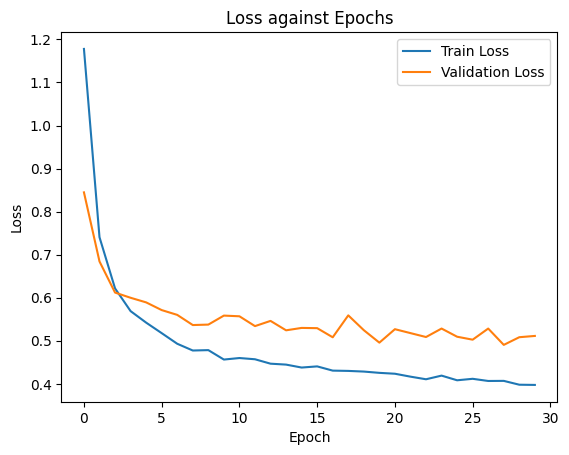

In [ ]:
#plotting line graph of training loss and validation loss
visualise_graph(training_data=train_loss, 
                validation_data=val_loss,
                y_label="Loss",
                x_label="Epochs" )

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/resnet_20_best.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 91.60000000000001, test_loss: 0.26850588992238045


#### Resnet152

##### Training

In [ ]:
model = PreTrainedCNNModels('Resnet152', 10, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'resnet152_10')

100%|██████████| 157/157 [00:28<00:00,  5.48it/s]


Epoch 1 completed, training loss: 1.1768664182371396
Validation loss: 0.9185855314135551, Validation Accuracy: 72.87


100%|██████████| 157/157 [00:28<00:00,  5.53it/s]


Epoch 2 completed, training loss: 0.8044416471651405
Validation loss: 0.7425116449594498, Validation Accuracy: 75.33
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.52it/s]


Epoch 3 completed, training loss: 0.681275024345726
Validation loss: 0.6972087919712067, Validation Accuracy: 76.20
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 4 completed, training loss: 0.627486528294861
Validation loss: 0.6507027484476566, Validation Accuracy: 76.93
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.51it/s]


Epoch 5 completed, training loss: 0.5887659772945817
Validation loss: 0.6234942202766737, Validation Accuracy: 77.67
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 6 completed, training loss: 0.5623726560052034
Validation loss: 0.6088271302481493, Validation Accuracy: 78.07
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.52it/s]


Epoch 7 completed, training loss: 0.5422138028843387
Validation loss: 0.5918210260570049, Validation Accuracy: 78.73
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.51it/s]


Epoch 8 completed, training loss: 0.5295082332601972
Validation loss: 0.5721758988996347, Validation Accuracy: 79.47
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 9 completed, training loss: 0.5184955699428632
Validation loss: 0.5776330704490343, Validation Accuracy: 79.33


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 10 completed, training loss: 0.5034655173113392
Validation loss: 0.5630677938461304, Validation Accuracy: 79.13
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.48it/s]


Epoch 11 completed, training loss: 0.4861476377696748
Validation loss: 0.5648877310256163, Validation Accuracy: 80.00


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 12 completed, training loss: 0.4732527939756964
Validation loss: 0.5560374471048514, Validation Accuracy: 80.00
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.52it/s]


Epoch 13 completed, training loss: 0.47350160654183404
Validation loss: 0.5505891206363837, Validation Accuracy: 79.87
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 14 completed, training loss: 0.4626425643255756
Validation loss: 0.5362439130743345, Validation Accuracy: 80.13
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.52it/s]


Epoch 15 completed, training loss: 0.4492100124146528
Validation loss: 0.5449032957355181, Validation Accuracy: 79.93


100%|██████████| 157/157 [00:28<00:00,  5.51it/s]


Epoch 16 completed, training loss: 0.4440819191135419
Validation loss: 0.5284723031024138, Validation Accuracy: 81.20
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 17 completed, training loss: 0.43810953683913895
Validation loss: 0.5344825660188993, Validation Accuracy: 80.27


100%|██████████| 157/157 [00:28<00:00,  5.51it/s]


Epoch 18 completed, training loss: 0.43638933976744393
Validation loss: 0.5407302776972452, Validation Accuracy: 80.13


100%|██████████| 157/157 [00:28<00:00,  5.45it/s]


Epoch 19 completed, training loss: 0.42563473456984113
Validation loss: 0.533492931475242, Validation Accuracy: 80.27


100%|██████████| 157/157 [00:28<00:00,  5.48it/s]


Epoch 20 completed, training loss: 0.4210896604000383
Validation loss: 0.5487732278803984, Validation Accuracy: 80.13


100%|██████████| 157/157 [00:28<00:00,  5.45it/s]


Epoch 21 completed, training loss: 0.4175946839675782
Validation loss: 0.531938881923755, Validation Accuracy: 80.47


100%|██████████| 157/157 [00:28<00:00,  5.46it/s]


Epoch 22 completed, training loss: 0.4125238509884306
Validation loss: 0.5149883242944876, Validation Accuracy: 81.40
Best model saved


100%|██████████| 157/157 [00:28<00:00,  5.44it/s]


Epoch 23 completed, training loss: 0.4061383546158007
Validation loss: 0.5241608756283919, Validation Accuracy: 80.80


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 24 completed, training loss: 0.40565078615382977
Validation loss: 0.522753452261289, Validation Accuracy: 81.40


100%|██████████| 157/157 [00:28<00:00,  5.49it/s]


Epoch 25 completed, training loss: 0.3945824658604944
Validation loss: 0.5207787478963534, Validation Accuracy: 81.47


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 26 completed, training loss: 0.3883717914295804
Validation loss: 0.5357806247969469, Validation Accuracy: 80.73


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 27 completed, training loss: 0.3826088172614954
Validation loss: 0.5171807818114758, Validation Accuracy: 81.33


100%|██████████| 157/157 [00:28<00:00,  5.49it/s]


Epoch 28 completed, training loss: 0.38283507620832724
Validation loss: 0.525990099956592, Validation Accuracy: 81.07


100%|██████████| 157/157 [00:28<00:00,  5.51it/s]


Epoch 29 completed, training loss: 0.38634744258063614
Validation loss: 0.5179223095377287, Validation Accuracy: 81.40


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Epoch 30 completed, training loss: 0.3763886040942684
Validation loss: 0.5245666665335497, Validation Accuracy: 81.13


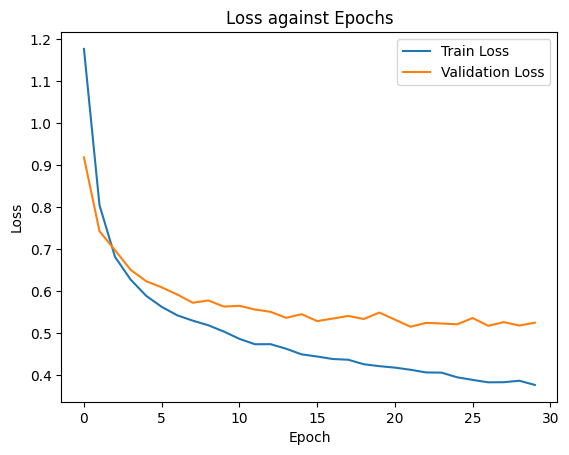

In [ ]:
visualise_graph(training_data=train_loss, 
                validation_data=val_loss,
                y_label="Loss",
                x_label="Epoch" )

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/resnet152_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 88.0, test_loss: 0.30991426669061184


#### EfficientNet

##### Training

In [ ]:
model = PreTrainedCNNModels('EfficientNet', 10, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'efficient_10')

100%|██████████| 157/157 [00:34<00:00,  4.55it/s]


Epoch 1 completed, training loss: 1.2884788061403165
Validation loss: 0.9753977532188097, Validation Accuracy: 74.07


100%|██████████| 157/157 [00:35<00:00,  4.42it/s]


Epoch 2 completed, training loss: 0.9033037777159624
Validation loss: 0.7525769099593163, Validation Accuracy: 75.60
Best model saved


100%|██████████| 157/157 [00:37<00:00,  4.24it/s]


Epoch 3 completed, training loss: 0.7560612885815323
Validation loss: 0.6739555870493253, Validation Accuracy: 76.80
Best model saved


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 4 completed, training loss: 0.6762321399655312
Validation loss: 0.6362850901981195, Validation Accuracy: 77.40
Best model saved


100%|██████████| 157/157 [00:35<00:00,  4.41it/s]


Epoch 5 completed, training loss: 0.636399779350135
Validation loss: 0.6217718496918678, Validation Accuracy: 78.20
Best model saved


100%|██████████| 157/157 [00:33<00:00,  4.71it/s]


Epoch 6 completed, training loss: 0.6060594088712316
Validation loss: 0.6227925891677538, Validation Accuracy: 78.20


100%|██████████| 157/157 [00:33<00:00,  4.73it/s]


Epoch 7 completed, training loss: 0.5874692735019004
Validation loss: 0.5994557092587153, Validation Accuracy: 77.87
Best model saved


100%|██████████| 157/157 [00:35<00:00,  4.43it/s]


Epoch 8 completed, training loss: 0.5715915687904236
Validation loss: 0.5946616853276888, Validation Accuracy: 79.27
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.52it/s]


Epoch 9 completed, training loss: 0.5563355712753952
Validation loss: 0.5872138515114784, Validation Accuracy: 79.13
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.50it/s]


Epoch 10 completed, training loss: 0.558081222947236
Validation loss: 0.5838750700155894, Validation Accuracy: 79.33
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.52it/s]


Epoch 11 completed, training loss: 0.532449110108576
Validation loss: 0.5823090846339861, Validation Accuracy: 80.07
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.54it/s]


Epoch 12 completed, training loss: 0.5314540973134861
Validation loss: 0.5686417805651823, Validation Accuracy: 79.87
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.50it/s]


Epoch 13 completed, training loss: 0.5204357918660352
Validation loss: 0.5808091275393963, Validation Accuracy: 79.60


100%|██████████| 157/157 [00:34<00:00,  4.52it/s]


Epoch 14 completed, training loss: 0.5078347820764894
Validation loss: 0.56765349706014, Validation Accuracy: 79.67
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.53it/s]


Epoch 15 completed, training loss: 0.5006389452773294
Validation loss: 0.5695669377843539, Validation Accuracy: 80.20


100%|██████████| 157/157 [00:35<00:00,  4.43it/s]


Epoch 16 completed, training loss: 0.5026572295434916
Validation loss: 0.5668653746445974, Validation Accuracy: 80.13
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.60it/s]


Epoch 17 completed, training loss: 0.4960127366576225
Validation loss: 0.5699503943324089, Validation Accuracy: 79.60


100%|██████████| 157/157 [00:33<00:00,  4.73it/s]


Epoch 18 completed, training loss: 0.4870554865545528
Validation loss: 0.5660380845268568, Validation Accuracy: 81.33
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.60it/s]


Epoch 19 completed, training loss: 0.4903265826261727
Validation loss: 0.5517534178992113, Validation Accuracy: 80.93
Best model saved


100%|██████████| 157/157 [00:33<00:00,  4.65it/s]


Epoch 20 completed, training loss: 0.48295139184423314
Validation loss: 0.5502764371534189, Validation Accuracy: 80.60
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.49it/s]


Epoch 21 completed, training loss: 0.4745722893317034
Validation loss: 0.5569051007429758, Validation Accuracy: 80.87


100%|██████████| 157/157 [00:33<00:00,  4.67it/s]


Epoch 22 completed, training loss: 0.46688278237725517
Validation loss: 0.5396839814881483, Validation Accuracy: 81.07
Best model saved


100%|██████████| 157/157 [00:34<00:00,  4.55it/s]


Epoch 23 completed, training loss: 0.4683931382598391
Validation loss: 0.5486295595765114, Validation Accuracy: 81.13


100%|██████████| 157/157 [00:40<00:00,  3.85it/s]


Epoch 24 completed, training loss: 0.4648578456442827
Validation loss: 0.5512866166730722, Validation Accuracy: 81.40


100%|██████████| 157/157 [00:37<00:00,  4.18it/s]


Epoch 25 completed, training loss: 0.45663742939378044
Validation loss: 0.54691098878781, Validation Accuracy: 81.13


100%|██████████| 157/157 [00:34<00:00,  4.58it/s]


Epoch 26 completed, training loss: 0.4615357751679269
Validation loss: 0.5480292203525702, Validation Accuracy: 80.87


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Epoch 27 completed, training loss: 0.45301531530489586
Validation loss: 0.5585015105704466, Validation Accuracy: 81.20


100%|██████████| 157/157 [00:36<00:00,  4.35it/s]


Epoch 28 completed, training loss: 0.45846339965322214
Validation loss: 0.5416948050260544, Validation Accuracy: 81.40


100%|██████████| 157/157 [00:35<00:00,  4.36it/s]


Epoch 29 completed, training loss: 0.454339377060058
Validation loss: 0.5419847704470158, Validation Accuracy: 80.87


100%|██████████| 157/157 [00:35<00:00,  4.38it/s]


Epoch 30 completed, training loss: 0.4474937114745948
Validation loss: 0.5406407577296098, Validation Accuracy: 81.80


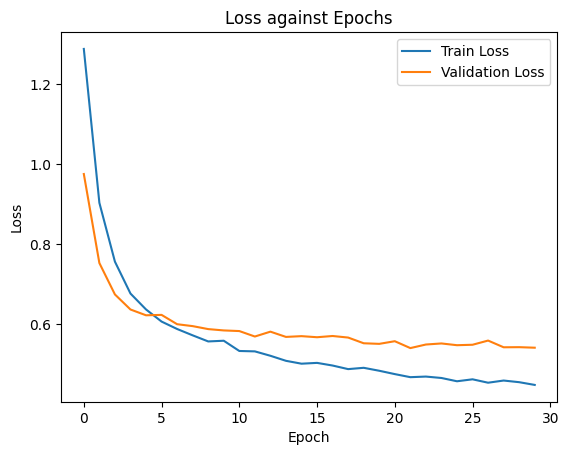

In [ ]:
#plotting line graph of training loss and validation loss
visualise_graph(training_data=train_loss, 
                validation_data=val_loss,
                y_label="Loss",
                x_label="Epochs" )

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/efficient_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 87.6, test_loss: 0.32694730535149574


#### DenseNet

##### Training

In [ ]:
model = PreTrainedCNNModels('DenseNet', 10, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'dense_10')

100%|██████████| 157/157 [00:21<00:00,  7.38it/s]


Epoch 1 completed, training loss: 1.0167830624398153
Validation loss: 0.7129331007599831, Validation Accuracy: 75.73


100%|██████████| 157/157 [00:20<00:00,  7.53it/s]


Epoch 2 completed, training loss: 0.6895228425028977
Validation loss: 0.622039711723725, Validation Accuracy: 77.67
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.50it/s]


Epoch 3 completed, training loss: 0.6182206424937886
Validation loss: 0.5787224719921747, Validation Accuracy: 79.40
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.48it/s]


Epoch 4 completed, training loss: 0.5825834306562023
Validation loss: 0.5618030627568563, Validation Accuracy: 79.87
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.56it/s]


Epoch 5 completed, training loss: 0.55727340195589
Validation loss: 0.5535514901081721, Validation Accuracy: 80.40
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.58it/s]


Epoch 6 completed, training loss: 0.5385931701796829
Validation loss: 0.5199245965729157, Validation Accuracy: 80.80
Best model saved


100%|██████████| 157/157 [00:21<00:00,  7.44it/s]


Epoch 7 completed, training loss: 0.5107007613227625
Validation loss: 0.5282583783070246, Validation Accuracy: 80.80


100%|██████████| 157/157 [00:20<00:00,  7.56it/s]


Epoch 8 completed, training loss: 0.49271098747374903
Validation loss: 0.5231874945263068, Validation Accuracy: 81.80


100%|██████████| 157/157 [00:20<00:00,  7.56it/s]


Epoch 9 completed, training loss: 0.48778008522501415
Validation loss: 0.526798564940691, Validation Accuracy: 82.20


100%|██████████| 157/157 [00:20<00:00,  7.56it/s]


Epoch 10 completed, training loss: 0.46446077582562806
Validation loss: 0.5258019802471002, Validation Accuracy: 82.47


100%|██████████| 157/157 [00:20<00:00,  7.54it/s]


Epoch 11 completed, training loss: 0.457501788617699
Validation loss: 0.49158825911581516, Validation Accuracy: 82.07
Best model saved


100%|██████████| 157/157 [00:21<00:00,  7.34it/s]


Epoch 12 completed, training loss: 0.4438544602910425
Validation loss: 0.4895443481703599, Validation Accuracy: 82.67
Best model saved


100%|██████████| 157/157 [00:21<00:00,  7.44it/s]


Epoch 13 completed, training loss: 0.43291725275243165
Validation loss: 0.4954417484501998, Validation Accuracy: 82.40


100%|██████████| 157/157 [00:21<00:00,  7.42it/s]


Epoch 14 completed, training loss: 0.4347618644594387
Validation loss: 0.5063960005839666, Validation Accuracy: 82.40


100%|██████████| 157/157 [00:21<00:00,  7.23it/s]


Epoch 15 completed, training loss: 0.41970826248834087
Validation loss: 0.496769189213713, Validation Accuracy: 82.73


100%|██████████| 157/157 [00:21<00:00,  7.31it/s]


Epoch 16 completed, training loss: 0.3991396862799954
Validation loss: 0.4864857420325279, Validation Accuracy: 82.87
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.49it/s]


Epoch 17 completed, training loss: 0.3940574372080481
Validation loss: 0.4894098527729511, Validation Accuracy: 82.53


100%|██████████| 157/157 [00:20<00:00,  7.52it/s]


Epoch 18 completed, training loss: 0.3904596113475265
Validation loss: 0.4823160395026207, Validation Accuracy: 82.93
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.52it/s]


Epoch 19 completed, training loss: 0.38023104922027345
Validation loss: 0.4879665933549404, Validation Accuracy: 83.33


100%|██████████| 157/157 [00:20<00:00,  7.53it/s]


Epoch 20 completed, training loss: 0.3737507395114109
Validation loss: 0.46966304009159404, Validation Accuracy: 83.87
Best model saved


100%|██████████| 157/157 [00:20<00:00,  7.55it/s]


Epoch 21 completed, training loss: 0.35605455156724164
Validation loss: 0.4988930926968654, Validation Accuracy: 82.60


100%|██████████| 157/157 [00:20<00:00,  7.59it/s]


Epoch 22 completed, training loss: 0.35619537010314356
Validation loss: 0.48178452750047046, Validation Accuracy: 84.00


100%|██████████| 157/157 [00:20<00:00,  7.60it/s]


Epoch 23 completed, training loss: 0.34923677858273694
Validation loss: 0.49864260852336884, Validation Accuracy: 83.53


100%|██████████| 157/157 [00:20<00:00,  7.60it/s]


Epoch 24 completed, training loss: 0.3531611035963532
Validation loss: 0.4865063118437926, Validation Accuracy: 83.40


100%|██████████| 157/157 [00:20<00:00,  7.58it/s]


Epoch 25 completed, training loss: 0.3399040672429808
Validation loss: 0.4840184437731902, Validation Accuracy: 84.07


100%|██████████| 157/157 [00:20<00:00,  7.56it/s]


Epoch 26 completed, training loss: 0.3495393154347778
Validation loss: 0.48960573102037114, Validation Accuracy: 83.60


100%|██████████| 157/157 [00:20<00:00,  7.54it/s]


Epoch 27 completed, training loss: 0.3331828179063311
Validation loss: 0.4730769669016202, Validation Accuracy: 84.07


100%|██████████| 157/157 [00:20<00:00,  7.57it/s]


Epoch 28 completed, training loss: 0.3320142314502388
Validation loss: 0.48861078172922134, Validation Accuracy: 83.73


100%|██████████| 157/157 [00:20<00:00,  7.57it/s]


Epoch 29 completed, training loss: 0.3117506061769595
Validation loss: 0.4976683308680852, Validation Accuracy: 84.20


100%|██████████| 157/157 [00:20<00:00,  7.54it/s]


Epoch 30 completed, training loss: 0.31771460113821515
Validation loss: 0.48445333540439606, Validation Accuracy: 83.80


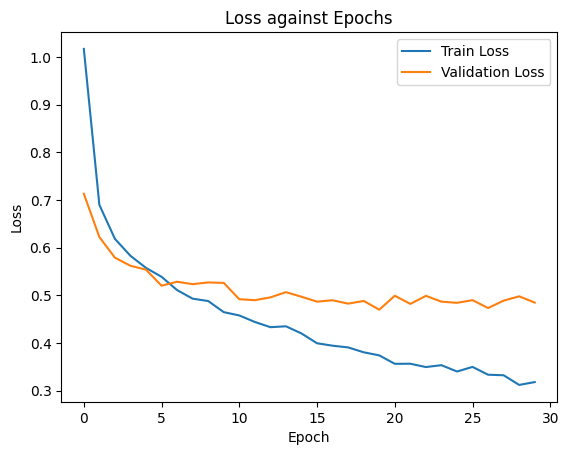

In [ ]:
#plotting line graph of training loss and validation loss
visualise_graph(training_data=train_loss, 
                validation_data=val_loss,
                y_label="Loss",
                x_label="Epochs" )

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/dense_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 89.60000000000001, test_loss: 0.2781300628557801


#### VGG16

##### Training

In [ ]:
model = PreTrainedCNNModels('VGG16', 10, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'vgg_10')

100%|██████████| 157/157 [00:51<00:00,  3.06it/s]


Epoch 1 completed, training loss: 0.9691132804390731
Validation loss: 0.6282152347266674, Validation Accuracy: 76.40


100%|██████████| 157/157 [00:51<00:00,  3.05it/s]


Epoch 2 completed, training loss: 0.7028354497472192
Validation loss: 0.5574562251567841, Validation Accuracy: 80.00
Best model saved


100%|██████████| 157/157 [00:52<00:00,  3.00it/s]


Epoch 3 completed, training loss: 0.63424482353174
Validation loss: 0.5655509034792582, Validation Accuracy: 79.60


100%|██████████| 157/157 [00:51<00:00,  3.07it/s]


Epoch 4 completed, training loss: 0.5946422128161047
Validation loss: 0.5192927370468775, Validation Accuracy: 81.13
Best model saved


100%|██████████| 157/157 [00:50<00:00,  3.12it/s]


Epoch 5 completed, training loss: 0.5538076553375099
Validation loss: 0.5180671450992426, Validation Accuracy: 81.20
Best model saved


100%|██████████| 157/157 [00:50<00:00,  3.11it/s]


Epoch 6 completed, training loss: 0.5402753041808013
Validation loss: 0.5142953333755335, Validation Accuracy: 81.40
Best model saved


100%|██████████| 157/157 [00:50<00:00,  3.11it/s]


Epoch 7 completed, training loss: 0.5126844851454352
Validation loss: 0.5203696911533674, Validation Accuracy: 81.20


100%|██████████| 157/157 [00:51<00:00,  3.03it/s]


Epoch 8 completed, training loss: 0.496260331409752
Validation loss: 0.5113427837689718, Validation Accuracy: 81.87
Best model saved


100%|██████████| 157/157 [00:52<00:00,  3.01it/s]


Epoch 9 completed, training loss: 0.48421807330884753
Validation loss: 0.5075504053384066, Validation Accuracy: 81.27
Best model saved


100%|██████████| 157/157 [00:51<00:00,  3.04it/s]


Epoch 10 completed, training loss: 0.47717012170773404
Validation loss: 0.49698920796314877, Validation Accuracy: 81.73
Best model saved


100%|██████████| 157/157 [00:51<00:00,  3.07it/s]


Epoch 11 completed, training loss: 0.4563769869933462
Validation loss: 0.48991544420520466, Validation Accuracy: 83.00
Best model saved


100%|██████████| 157/157 [00:51<00:00,  3.06it/s]


Epoch 12 completed, training loss: 0.45062775843462366
Validation loss: 0.5028152900437514, Validation Accuracy: 82.40


100%|██████████| 157/157 [00:51<00:00,  3.04it/s]


Epoch 13 completed, training loss: 0.4280212194107141
Validation loss: 0.49369693361222744, Validation Accuracy: 81.93


100%|██████████| 157/157 [00:51<00:00,  3.04it/s]


Epoch 14 completed, training loss: 0.41956837408861536
Validation loss: 0.49298680822054547, Validation Accuracy: 82.47


100%|██████████| 157/157 [00:50<00:00,  3.10it/s]


Epoch 15 completed, training loss: 0.41663192820017503
Validation loss: 0.4821424186229706, Validation Accuracy: 83.47
Best model saved


100%|██████████| 157/157 [00:50<00:00,  3.13it/s]


Epoch 16 completed, training loss: 0.40573148211096505
Validation loss: 0.4799227211624384, Validation Accuracy: 83.00
Best model saved


100%|██████████| 157/157 [00:49<00:00,  3.16it/s]


Epoch 17 completed, training loss: 0.3941847296657076
Validation loss: 0.46722945912430686, Validation Accuracy: 83.73
Best model saved


100%|██████████| 157/157 [00:49<00:00,  3.16it/s]


Epoch 18 completed, training loss: 0.39005914264044184
Validation loss: 0.4900360591709614, Validation Accuracy: 82.53


100%|██████████| 157/157 [00:51<00:00,  3.03it/s]


Epoch 19 completed, training loss: 0.3722965098490381
Validation loss: 0.4907914809882641, Validation Accuracy: 83.00


100%|██████████| 157/157 [00:51<00:00,  3.07it/s]


Epoch 20 completed, training loss: 0.3617592925668522
Validation loss: 0.4947176091372967, Validation Accuracy: 83.27


100%|██████████| 157/157 [00:51<00:00,  3.03it/s]


Epoch 21 completed, training loss: 0.3557017669556247
Validation loss: 0.5010598947604498, Validation Accuracy: 83.27


100%|██████████| 157/157 [00:51<00:00,  3.05it/s]


Epoch 22 completed, training loss: 0.35400041956810435
Validation loss: 0.4976066363354524, Validation Accuracy: 83.07


100%|██████████| 157/157 [00:51<00:00,  3.04it/s]


Epoch 23 completed, training loss: 0.3485115423893473
Validation loss: 0.4982396165529887, Validation Accuracy: 82.87


100%|██████████| 157/157 [00:51<00:00,  3.02it/s]


Epoch 24 completed, training loss: 0.33345633109284056
Validation loss: 0.5005654369791349, Validation Accuracy: 83.73


100%|██████████| 157/157 [00:52<00:00,  3.00it/s]


Epoch 25 completed, training loss: 0.34145214944888075
Validation loss: 0.48186262883245945, Validation Accuracy: 84.33


100%|██████████| 157/157 [00:52<00:00,  2.96it/s]


Epoch 26 completed, training loss: 0.3158199937100623
Validation loss: 0.5146148422112068, Validation Accuracy: 83.40


100%|██████████| 157/157 [00:54<00:00,  2.86it/s]


Epoch 27 completed, training loss: 0.3179396279868047
Validation loss: 0.5049160073200861, Validation Accuracy: 83.53


100%|██████████| 157/157 [00:53<00:00,  2.95it/s]


Epoch 28 completed, training loss: 0.3142876058437262
Validation loss: 0.5090650444229444, Validation Accuracy: 83.87


100%|██████████| 157/157 [00:52<00:00,  2.98it/s]


Epoch 29 completed, training loss: 0.30946701935901766
Validation loss: 0.5225679712990919, Validation Accuracy: 83.73


100%|██████████| 157/157 [00:53<00:00,  2.93it/s]


Epoch 30 completed, training loss: 0.3048621697980127
Validation loss: 0.4963900223374367, Validation Accuracy: 84.80


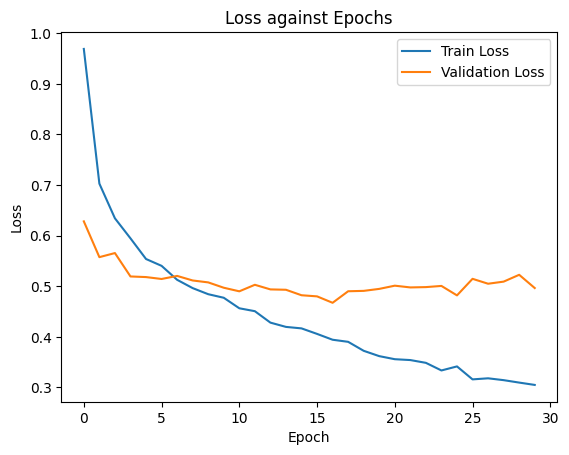

In [ ]:
#plotting line graph of training loss and validation loss
visualise_graph(training_data=train_loss, 
                validation_data=val_loss,
                y_label="Loss",
                x_label="Epochs" )

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/vgg_10_30.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 91.2, test_loss: 0.2664759699255228


#### MaxVit

##### Training

In [ ]:
model = PreTrainedCNNModels('MaxVit', 10, len(train_dataset.classes)).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_loss, val_loss = finetuning_train(model,
                                    criterion,
                                    optimizer,
                                    train_dataloader,
                                    val_dataloader,
                                    30,
                                    device,
                                    'maxvit_10')

100%|██████████| 157/157 [00:26<00:00,  5.93it/s]


Epoch 1 completed, training loss: 1.190666708217305
Validation loss: 0.8770246108373007, Validation Accuracy: 73.40


100%|██████████| 157/157 [00:24<00:00,  6.40it/s]


Epoch 2 completed, training loss: 0.7650523694457522
Validation loss: 0.6973676557342211, Validation Accuracy: 76.47
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.42it/s]


Epoch 3 completed, training loss: 0.6442139826382801
Validation loss: 0.6294733732938766, Validation Accuracy: 78.47
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.41it/s]


Epoch 4 completed, training loss: 0.5879928308307745
Validation loss: 0.6065250734488169, Validation Accuracy: 76.87
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.37it/s]


Epoch 5 completed, training loss: 0.5505417287349701
Validation loss: 0.591976006825765, Validation Accuracy: 78.27
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.42it/s]


Epoch 6 completed, training loss: 0.5325921333519517
Validation loss: 0.5772787084182104, Validation Accuracy: 78.27
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.39it/s]


Epoch 7 completed, training loss: 0.5158140368902
Validation loss: 0.6057898749907812, Validation Accuracy: 76.80


100%|██████████| 157/157 [00:24<00:00,  6.29it/s]


Epoch 8 completed, training loss: 0.5011287136062695
Validation loss: 0.5736273527145386, Validation Accuracy: 78.00
Best model saved


100%|██████████| 157/157 [00:25<00:00,  6.09it/s]


Epoch 9 completed, training loss: 0.49278209676408463
Validation loss: 0.5765828005969524, Validation Accuracy: 79.47


100%|██████████| 157/157 [00:25<00:00,  6.12it/s]


Epoch 10 completed, training loss: 0.48983745305401505
Validation loss: 0.5583898052573204, Validation Accuracy: 80.13
Best model saved


100%|██████████| 157/157 [00:25<00:00,  6.16it/s]


Epoch 11 completed, training loss: 0.48304328588163775
Validation loss: 0.5690482358137766, Validation Accuracy: 78.53


100%|██████████| 157/157 [00:25<00:00,  6.14it/s]


Epoch 12 completed, training loss: 0.4747269051090168
Validation loss: 0.5595461192230383, Validation Accuracy: 79.33


100%|██████████| 157/157 [00:25<00:00,  6.13it/s]


Epoch 13 completed, training loss: 0.4594912868776139
Validation loss: 0.5601470172405243, Validation Accuracy: 80.07


100%|██████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 14 completed, training loss: 0.454706850989609
Validation loss: 0.5721573159098625, Validation Accuracy: 78.47


100%|██████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 15 completed, training loss: 0.45480223303767525
Validation loss: 0.5475266426801682, Validation Accuracy: 79.87
Best model saved


100%|██████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 16 completed, training loss: 0.44969268408930224
Validation loss: 0.5277713599304358, Validation Accuracy: 80.73
Best model saved


100%|██████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 17 completed, training loss: 0.4513752991986123
Validation loss: 0.5509875242908796, Validation Accuracy: 79.20


100%|██████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 18 completed, training loss: 0.44655272136827945
Validation loss: 0.5473526380956173, Validation Accuracy: 79.40


100%|██████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 19 completed, training loss: 0.4439715172644633
Validation loss: 0.5915361990531286, Validation Accuracy: 78.60


100%|██████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 20 completed, training loss: 0.4298829272104676
Validation loss: 0.5447805263102055, Validation Accuracy: 79.67


100%|██████████| 157/157 [00:25<00:00,  6.19it/s]


Epoch 21 completed, training loss: 0.4398844619845129
Validation loss: 0.5533565891285738, Validation Accuracy: 79.33


100%|██████████| 157/157 [00:25<00:00,  6.17it/s]


Epoch 22 completed, training loss: 0.440110785471406
Validation loss: 0.5481952565411726, Validation Accuracy: 79.33


100%|██████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 23 completed, training loss: 0.42708251051082735
Validation loss: 0.5606528619925181, Validation Accuracy: 79.47


100%|██████████| 157/157 [00:25<00:00,  6.18it/s]


Epoch 24 completed, training loss: 0.43182664359830747
Validation loss: 0.5229818746447563, Validation Accuracy: 80.20
Best model saved


100%|██████████| 157/157 [00:25<00:00,  6.15it/s]


Epoch 25 completed, training loss: 0.42769430577754974
Validation loss: 0.5415254483620325, Validation Accuracy: 79.93


100%|██████████| 157/157 [00:25<00:00,  6.11it/s]


Epoch 26 completed, training loss: 0.415324681219022
Validation loss: 0.5183461122214794, Validation Accuracy: 79.93
Best model saved


100%|██████████| 157/157 [00:25<00:00,  6.28it/s]


Epoch 27 completed, training loss: 0.4157423919932857
Validation loss: 0.5185317409535249, Validation Accuracy: 81.00


100%|██████████| 157/157 [00:24<00:00,  6.35it/s]


Epoch 28 completed, training loss: 0.4179959416769113
Validation loss: 0.5066904053092003, Validation Accuracy: 81.27
Best model saved


100%|██████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 29 completed, training loss: 0.4174785309346618
Validation loss: 0.5197437008221945, Validation Accuracy: 81.20


100%|██████████| 157/157 [00:24<00:00,  6.36it/s]


Epoch 30 completed, training loss: 0.41533045679520647
Validation loss: 0.5217266753315926, Validation Accuracy: 80.07


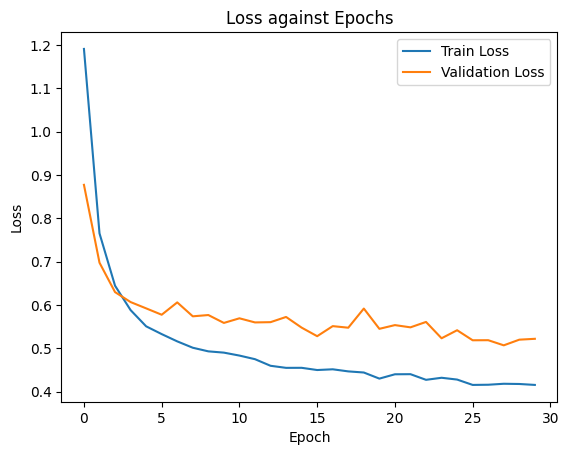

In [ ]:
#plotting line graph of training loss and validation loss
visualise_graph(training_data=train_loss, 
                validation_data=val_loss,
                y_label="Loss",
                x_label="Epochs" )

##### Evaluation

In [ ]:
best_model = torch.load('../models/cnn/maxvit_20_best.pt')

In [ ]:
accuracy, avg_test_loss = finetuning_eval(best_model,
                                        criterion,
                                        test_dataloader,
                                        device)

print(f"Test accuracy: {accuracy}, test_loss: {avg_test_loss}")

Test accuracy: 88.4, test_loss: 0.2987425457686186


#### Others

In [ ]:
#### Others
model = PreTrainedCNNModels('SqueezeNet', 1, len(train_dataset.classes)).to(device)